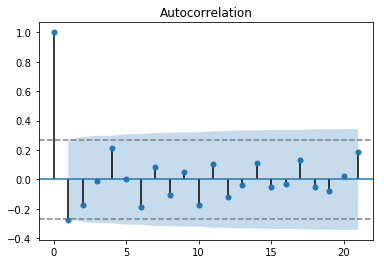

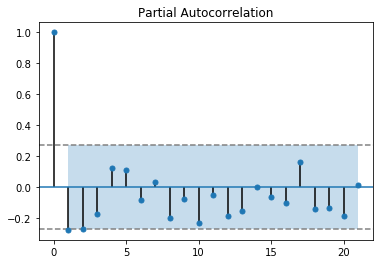

In [ ]:
%cd D:\\gejun\\Documents\\Git\\YuEbaoPrediction\\LSTM_prediction

# 使用ARIMA 预测
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import sys
from statsmodels.tsa.arima_model import ARMA

def mape(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true))
    
    
# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def proper_model(ts_log_diff, maxLag):
    best_p = 0
    best_q = 0
    best_bic = sys.maxsize
    best_model=None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1)
            except:
                continue
            bic = results_ARMA.bic
            print (bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    print(best_p,best_q,best_model)

df = pd.read_csv('../file/3_8_mean_purchase_residual.csv', index_col = 'date' , parse_dates=[0])

# df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')
# 
labels = ['mean_residual', 'actual', 'predict']

mean_residual = df['mean_residual']
mean_residual.plot()
plt.title('mean_residual')
plt.show()



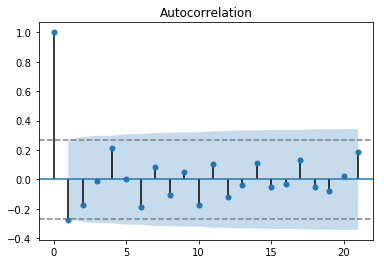

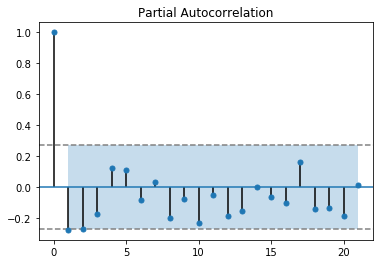

In [48]:
plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(mean_residual)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_residual)), linestyle='--', color='gray')
plot_acf(mean_residual, ax=plt.gca(), lags=21)
plt.show()


plt.axhline(y=-1.96/np.sqrt(len(mean_residual)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(mean_residual)), linestyle='--', color='gray')
plot_pacf(mean_residual, ax=plt.gca(), lags=21)
plt.show()


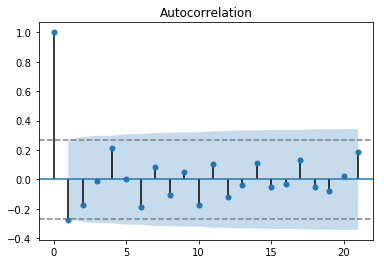

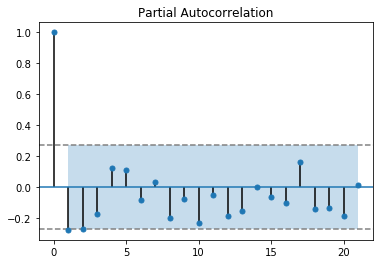

In [47]:


proper_model(mean_residual, 10)  #(8,7)用于求出最佳的p和q的值


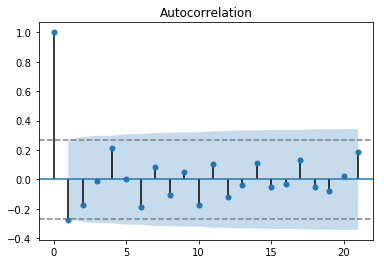

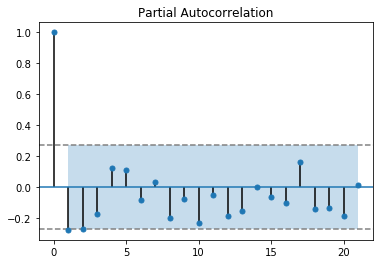

In [45]:


model = ARMA(ts_diff_1, order=(0, 0))
result_arma = model.fit(disp=-1, method='css')

predict_ts = result_arma.predict()

predict_ts.plot(label='predicted')
ts_diff_1.plot(label='original')
plt.legend(loc='best')
plt.show()

recovery_diff_1 = predict_diff_recover(predict_ts, [1])
recovery_diff_1.plot()
plt.show()

rol_sum = total_purchase_original.rolling(window=6).sum()
total_purchase_prediction = recovery_diff_1 * 7 - rol_sum.shift(1)

total_purchase_prediction.plot(label='predicted')
total_purchase_original.plot(label='original')

plt.legend(loc='best')
plt.show()

total_purchase_residual = mean_residual - total_purchase_prediction
total_purchase_residual_values = total_purchase_residual.values[8:]
